## ***Severstal: Steel Defect Detection***

# **Preprocessing data**


In [1]:
import pandas as pd

import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt

from skimage import io
from PIL import Image
import numpy as np
import cv2


from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import transforms,models
import torch.optim as optim
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import os

device = torch.device("cuda:0")
path_to_map = "train.csv"
path_to_submittion = "sample_submission.csv"
path_to_train = "train_images"
path_to_test = "test_images"

In [2]:
markup_map = pd.read_csv(path_to_map)

In [3]:
markup_map.head(2)

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...

In [4]:
def plot_class_histogram(markup_map, title=None):
  ax = sns.catplot(x='ClassId', data=markup_map, kind="count", palette="ch:.25")
  ax.fig.suptitle(title or 'Распределение классов повреждений')
  ax.fig.set_size_inches(10,5)
  plt.ylim(0, markup_map.ClassId.value_counts().max() + 100)
  plt.show()

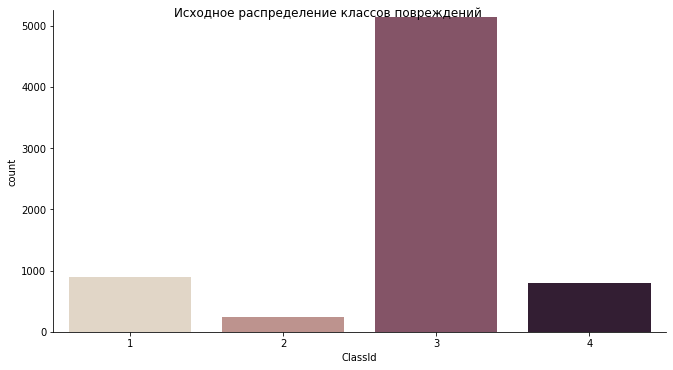

In [5]:
plot_class_histogram(markup_map, title='Исходное распределение классов повреждений')

In [6]:
def get_normal_map(markup_map, minimal_percent=None):
  data = {
    'ImageId':[], 
    1:[], 
    2:[], 
    3:[], 
    4:[]
  }
  
  markup_map.sort_values('ImageId')
  minimal_samples = markup_map.ClassId.value_counts().max()

  if minimal_percent:
    minimal_samples = int(markup_map.ClassId.value_counts().min() * (1 + minimal_percent))

  markup_map = markup_map.groupby('ClassId').head(minimal_samples)

  for row in markup_map.iloc:
    if data['ImageId'] and data['ImageId'][-1] == row['ImageId']:
      data[row['ClassId']].append(row['EncodedPixels'])
    else:
      data['ImageId'].append(row['ImageId'])

      for class_id in range(1, 5):
        if len(data[class_id]) != len(data['ImageId']) - 1:
          data[class_id].append(None)

      data[row['ClassId']].append(row['EncodedPixels'])
  for class_id in range(1, 5):
      if len(data[class_id]) != len(data['ImageId']):
        data[class_id].append(None)

  return pd.DataFrame(data)

In [7]:
def plot_normal_map_class_histogram(normal_map, title=None):
  classId = []
  [classId.extend([class_id] * normal_map[class_id].notna().sum()) for class_id in range(1, 5)]

  plot_class_histogram(pd.DataFrame(classId, columns=['ClassId']), title=title)

In [8]:
normal_map = get_normal_map(markup_map,minimal_percent= 2)

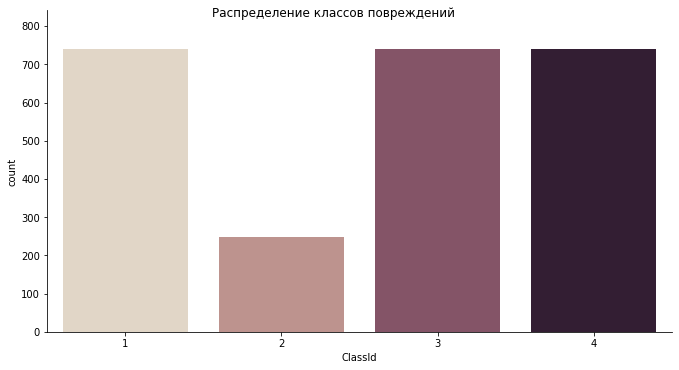

In [9]:
plot_normal_map_class_histogram(normal_map)

## Segmentation

In [10]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]


def get_image_mask(idx):
  masks = np.zeros((256, 1600, 4), dtype=np.uint8)
  labels = normal_map.iloc[idx][1:]
  for i, label in enumerate(labels):
    if not pd.isnull(label):
      label = label.split(" ")

      positions = map(int, label[0::2])
      length = map(int, label[1::2])
      mask = np.zeros(256 * 1600, dtype=np.uint8)
      for pos, le in zip(positions, length):
          mask[pos - 1:pos + le - 1] = 1

      masks[:, :, i] = mask.reshape(256, 1600, order='F')
  return masks.transpose(2, 0, 1)


def show_image_mask(idx,image = None ,mask = None):
  img = cv2.imread(str(path_to_train + '/' + normal_map.ImageId[idx])) if image == None else image.numpy()
  labels = list()
  masks =  get_image_mask(idx) if mask == None else mask.numpy()

  for ch in range(4):
    if masks[ch].max() != 0:
      labels.append(ch)
      print(ch)

      contours, _ = cv2.findContours(np.uint8(masks[ch]), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

      for i in range(0, len(contours)):
        cv2.polylines(img, contours[i], True, palet[ch], 2)

  plt.figure(figsize=(20, 5))
  plt.title('ClassId = %s' % labels)
  plt.imshow(img)
  plt.show()



In [16]:
class DefectsSegmentationDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, subset="train"):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = csv_file
        self.root_dir = root_dir
        self.transform = transform
        self.subset = subset
        
    def __getclasses__(self):
        return self.labels_frame['ClassId'].unique().tolist()

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx, 0])
        
        image = cv2.imread(img_path)
        
        if self.subset == "train":
            mask = make_mask(idx, self.labels_frame)
            augment = self.transform(image=image, mask=mask)
            
            mask = augment["mask"].permute(2, 0, 1)
            image = augment["image"]
        else:
            augment = self.transform(image=image)
            return augment["image"], img_path.split("/")[-1]
        
        return image, mask
        
def make_mask(row_id, df):
    
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][1:]
    masks = np.zeros((256, 1600, 4), dtype=np.float32)

    for idx, label in enumerate(labels.values):
      if not pd.isnull(label) :
        label = label.split(" ")

        positions = map(int, label[0::2])
        length = map(int, label[1::2])

        mask = np.zeros(256 * 1600, dtype=np.uint8)

        for pos, le in zip(positions, length):
          mask[pos:(pos + le)] = 1

        masks[:, :, idx] = mask.reshape(256, 1600, order='F')

    return masks

In [22]:
def prep_dataset(data_train, batch_size = 4,):
  data_size = len(data_train)

  validation_split = 0.2
  split = int(np.floor(validation_split * data_size))
  indices = list(range(data_size))
  np.random.shuffle(indices)
  train_indices,val_indices = indices[split:],indices[:split]

  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)

  train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                                   sampler=train_sampler)
    
  val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                                 sampler=val_sampler)

  return train_loader, val_loader

In [23]:
tfs = albu.Compose([
#     albu.RandomBrightnessContrast(0.3,p=0.2),
#     albu.HorizontalFlip(p = 0.5),
    albu.VerticalFlip(p = 0.5),
#     albu.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
    
  ])

In [24]:
train_data = DefectsSegmentationDataset(normal_map, path_to_train, transform=tfs)
train_loader, val_loader = prep_dataset(train_data)

3


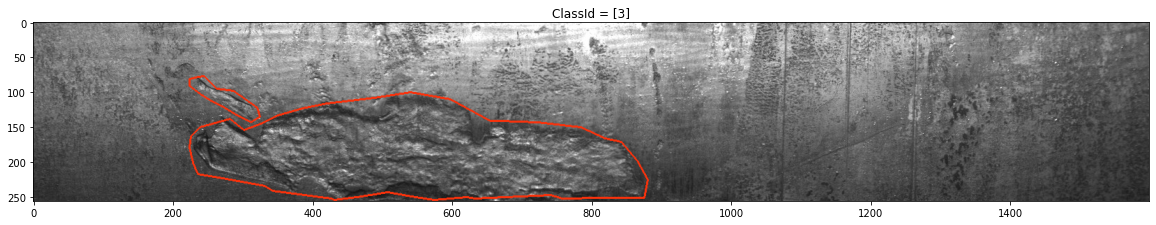

In [26]:
show_image_mask(225, image = train_data[1273][0].permute(1, 2, 0), mask = train_data[1273][1])

In [28]:
class BinaryDiceLoss(nn.Module):
    """
    Dice loss of binary class
    """
    def __init__(self, smooth=1, p=1, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)
        
        num = 2.0*torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth
        
        
        loss = 1 -  num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

class DiceLoss(nn.Module):
    """
    Weight Dice loss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        predict = F.sigmoid(predict)
        dice = BinaryDiceLoss(**self.kwargs)
#         bce = nn.BCELoss(**self.kwargs)
        
        dices_loss = 0
#         bces_loss = bce(predict, target)
        
        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i]) # считаем loss по батчу
#                 bce_loss = bce(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
#                     bce_loss *= self.weights[i]
                    
                dices_loss += dice_loss
#                 bces_loss += bce_loss
                
#         loss = bces_loss - (dice_loss/target.shape[1]).log()
                
        return dice_loss/target.shape[1]

In [27]:
import re
import torch.nn as nn


class Activation(nn.Module):

    def __init__(self, name, **params):

        super(Activation,self).__init__()

        if name is None or name == 'identity':
            self.activation = nn.Identity(**params)
        elif name == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif name == 'softmax2d':
            self.activation = nn.Softmax(dim=1, **params)
        elif name == 'softmax':
            self.activation = nn.Softmax(**params)
        elif name == 'logsoftmax':
            self.activation = nn.LogSoftmax(**params)
        elif name == 'tanh':
            self.activation = nn.Tanh()
        elif name == 'argmax':
            self.activation = ArgMax(**params)
        elif name == 'argmax2d':
            self.activation = ArgMax(dim=1, **params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError('Activation should be callable/sigmoid/softmax/logsoftmax/tanh/None; got {}'.format(name))

    def forward(self, x):
        return self.activation(x)
    

class IoU(nn.Module):
    __name__ = 'iou_score'

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        return self._iou_score(
            y_pr, y_gt,
        )
    
    def _iou_score(self, pr, gt):
        pr = F.sigmoid(pr)
        
        with torch.no_grad():
            total_IoU = 0
            for i in range(gt.shape[1]):
                predict = self._threshold(pr[:,i],self.threshold)
                
                predict = predict.contiguous().view(predict.shape[0], -1)
                target = gt[:,i].contiguous().view(gt[:,i].shape[0], -1)
                
                intersection = torch.sum(predict * target)
                union = torch.sum(predict) + torch.sum(target) - intersection + self.eps
                
                total_IoU += ((intersection + self.eps) / union).mean()
            
        return total_IoU / gt.shape[1]
    
    def _threshold(self, x, threshold=None):
        if threshold is not None:
            return (x > threshold).type(x.dtype)
        else:
            return x
        

In [29]:
import gc

def train_model(model,train_loader,val_loader,loss,optimizer, num_epochs, writer, metric):
    loss_vals = list()
    scheduler = ReduceLROnPlateau(optimizer)
    for epoch in range(num_epochs):
        
        print(epoch)
        model.train()
        
        loss_accum = 0
        IoU_accum_tr = 0
        IoU_value = 0
        for i_step, (x, y) in enumerate(train_loader):
                
                x_gpu = x.to(device=device)
                y_gpu = y.to(device=device)
                
                prediction = model(x_gpu)
                
                loss_value = loss(prediction, y_gpu)
                
                IoU_value = metric(prediction.to("cpu").contiguous(), y_gpu.to("cpu").contiguous())

                optimizer.zero_grad()
                loss_value.backward()
                optimizer.step()
                
                
                loss_accum += loss_value
                IoU_accum_tr += IoU_value
                
                del x_gpu
                del y_gpu
        
        ave_loss = loss_accum / (i_step + 1)
        ave_iou = IoU_accum_tr / (i_step + 1)
        
        writer.add_scalar("DiceLoss/train", ave_loss, epoch)
        writer.add_scalar("IoU/train", ave_iou, epoch)

        val_IoU, loss_val = compute_valid(model, val_loader, loss, epoch, metric)
        loss_vals.append(loss_val)
        
        writer.add_scalar("DiceLoss/valid", loss_val, epoch)
        writer.add_scalar("IoU/valid", val_IoU, epoch)
        
        if epoch > 0:
            if min(loss_vals) == loss_val:
                torch.save(model, "test3.pth")
        
#         writer.add_scalar("Lr/epoch", scheduler.get_last_lr()[-1], epoch)
        scheduler.step(epoch)

        print(f"Train Dice loss: {ave_loss}, Val Dice loss: {loss_val}, Train IoU: {ave_iou}, Val IoU: {val_IoU}")
        
#         print('Epoch:', epoch, 'LR:', scheduler.get_last_lr())
              
    return model

def compute_valid(model, loader, loss,epoch,metric):
    model.eval()
    with torch.no_grad():
              
        loss_accum = 0
        IoU_accum_val = 0
        
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device=device, dtype=torch.float)
            y_gpu = y.to(device=device,)

            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            
            
            loss_accum += loss_value
            IoU_accum_val += metric(prediction.to("cpu"), y_gpu.to("cpu"))

            del x_gpu
            del y_gpu
                
        loss_val = loss_accum / (i_step + 1)
        val_IoU  =  IoU_accum_val / (i_step + 1)
        return val_IoU, loss_val

In [25]:
from models.ResNextUnet import ResNextUNet

In [29]:
# class_weights = [1,1,1,1]
transfer = ["down0","down1","down2","down3","down4","backbone"]
# transfer = ["layer0","layer1","layer2","layer3","layer4","base_layers"]
model = ResNextUNet(3,4) #ResNextUNet(3,4)#
model = model.to(device)
loss = nn.BCEWithLogitsLoss()
num_epochs = 25
metric = IoU()

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-05)

for name,par in model.named_parameters():
    if name.split(".")[0] in transfer:
        par.requires_grad = False

In [30]:
optimizer = torch.optim.Adam([{"params":[param for name, param in model.named_parameters() 
                                         if name.split(".")[0] not in transfer], "lr":1e-3},
                             ], lr = 1e-03, weight_decay = 1e-05)

In [28]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, verbose=True, min_lr=1e-5)

In [26]:
writer = SummaryWriter()
model = train_model(model,train_loader,val_loader,loss,optimizer,num_epochs,writer,metric)
writer.flush()
writer.close()

0


/home/viktor.kumpan/.miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Dice loss: 0.20288819074630737, Val Dice loss: 0.20296399295330048, Train IoU: 0.359561562538147, Val IoU: 0.3659563660621643


/home/viktor.kumpan/.miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict
2


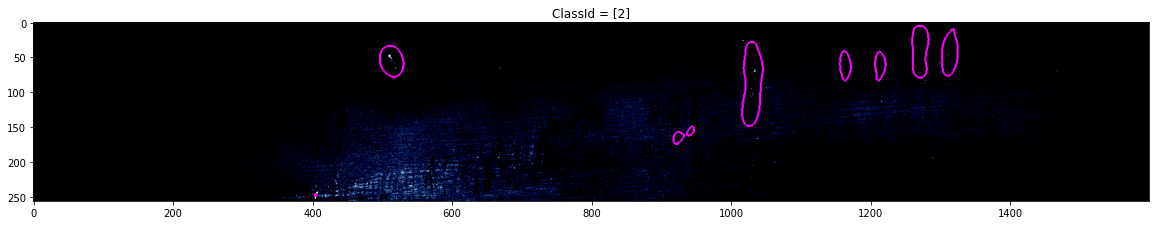

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MarkUp
2


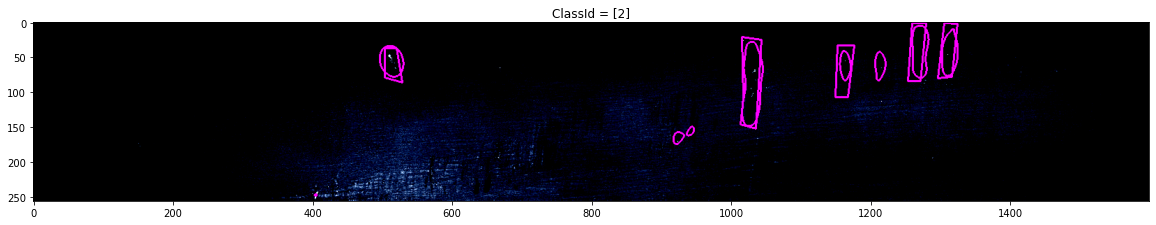

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict
2
3


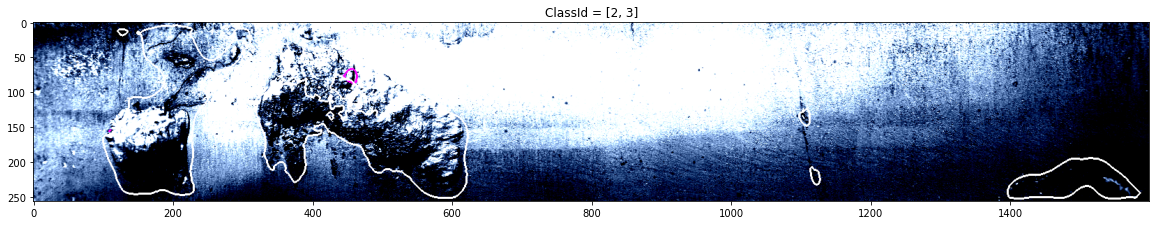

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MarkUp
3


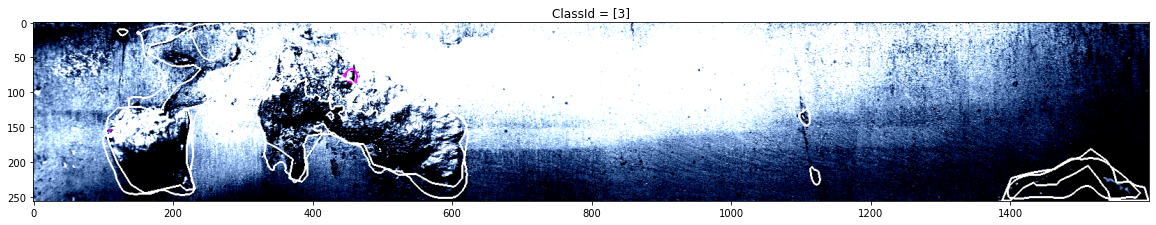

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict
2
3


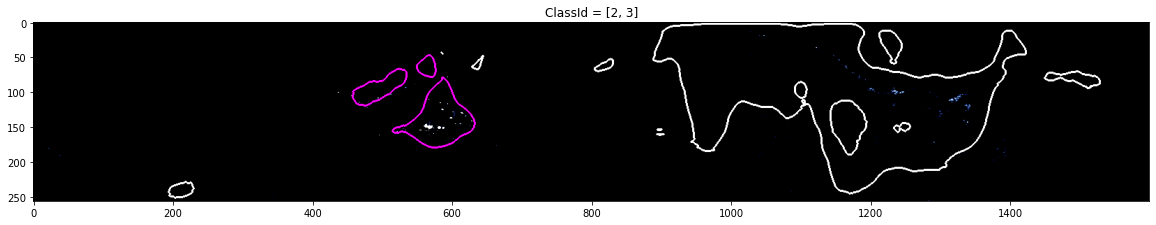

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MarkUp
3


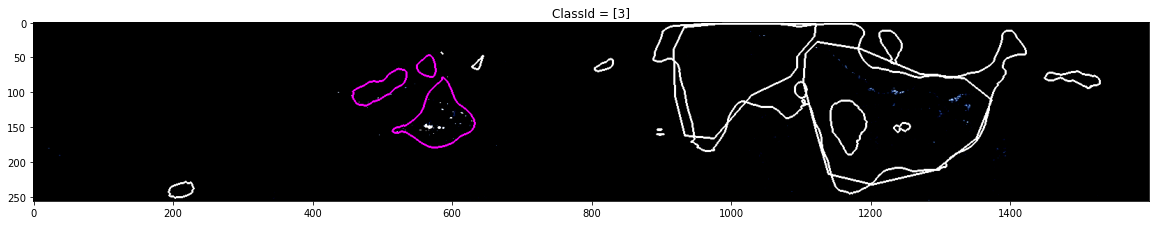

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict
2
3


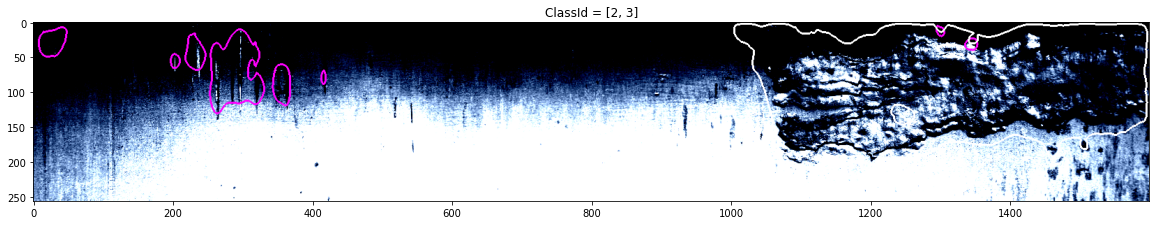

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MarkUp
2
3


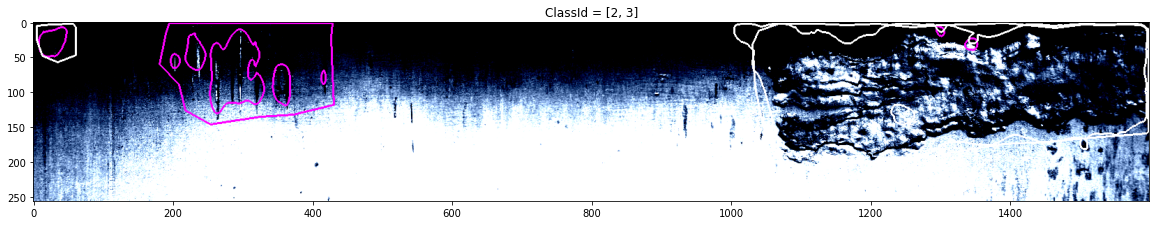

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict
2
3


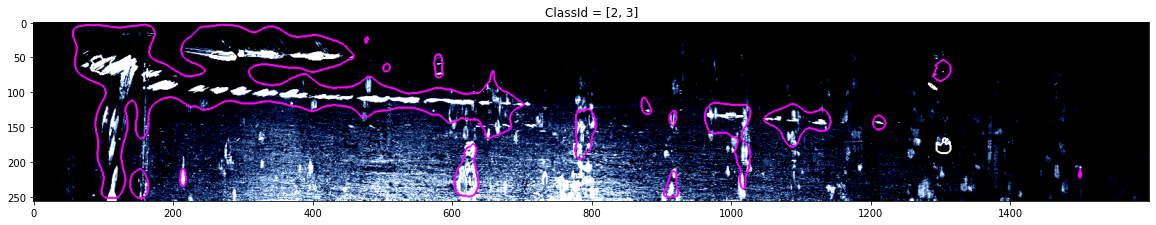

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MarkUp
2


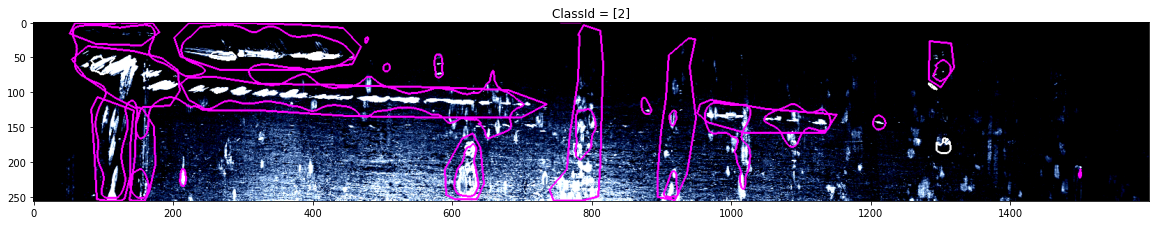

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict
2
3


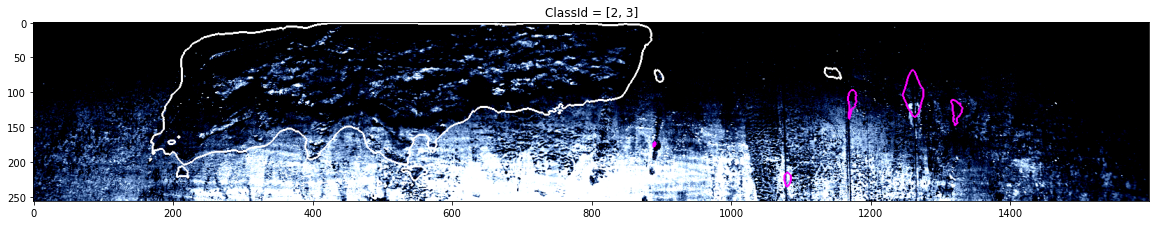

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MarkUp
3


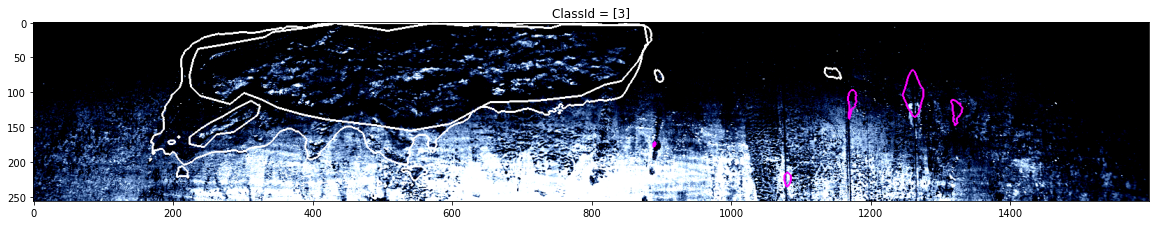

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict
2
3


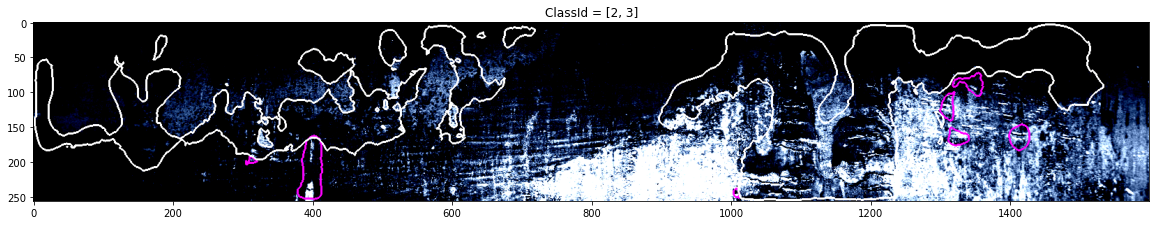

MarkUp
2
3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


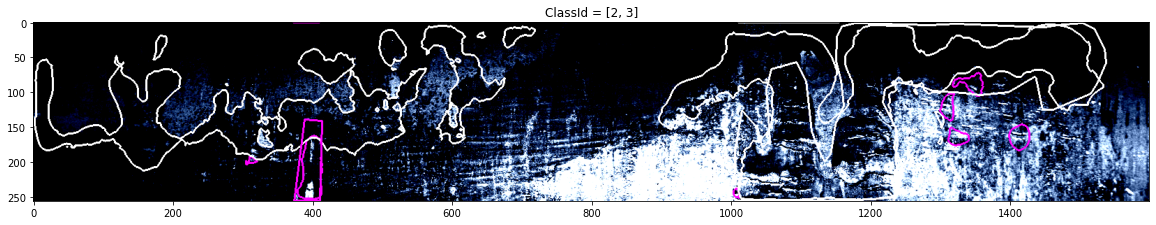

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict
2


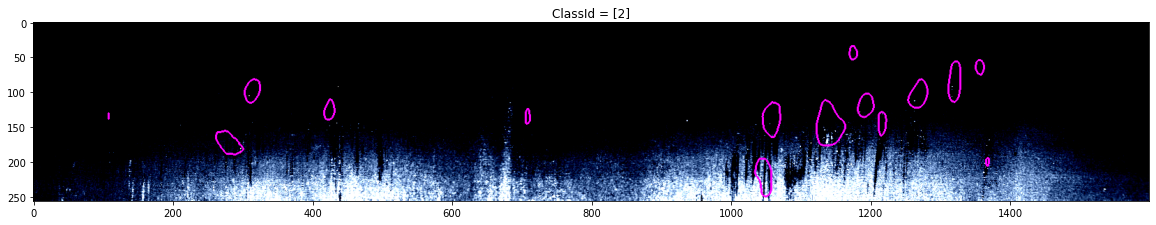

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MarkUp
2


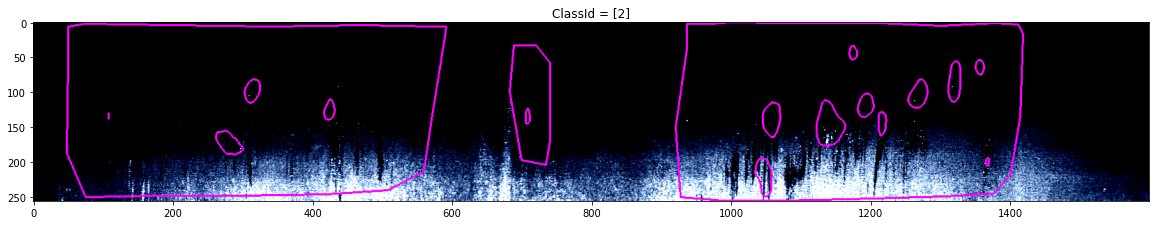

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict
2
3


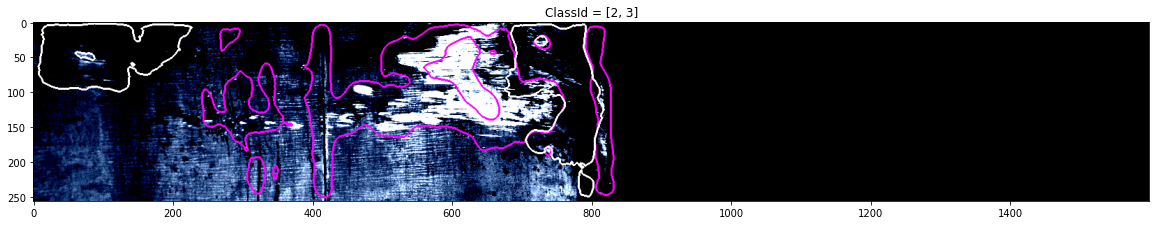

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MarkUp
2


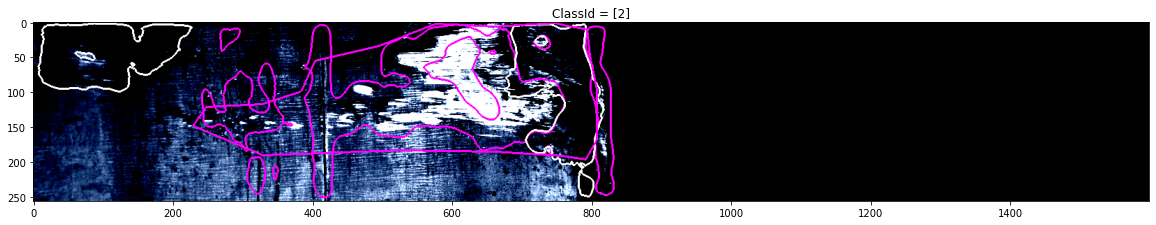

In [43]:
idx = [343,1183,364,55,92,1273,504,536,538]
model = torch.load("test1.pth")
threshold_mask_pixel = [ 0.2, 0.2, 0.2, 0.2]
model.to("cpu")
model.eval()
for i in idx:
    img, mask = train_data[i]
    predict = F.sigmoid(model(img.contiguous().unsqueeze(0))[0])
    pr_mask = get_normal_pred_mask(predict)
    print("Predict")
    show_image_mask(225, image = img.permute(1, 2, 0), mask = pr_mask.detach())
    print("MarkUp")
    show_image_mask(225, image = img.permute(1, 2, 0), mask = mask)

In [ ]:
# Submition

In [16]:
test_tfs = albu.Compose([
    #albu.HorizontalFlip(p = 0.5),
    #transforms.RandomRotation(degrees = 60),
    #transforms.ColorJitter(saturation = 0.3, brightness=0.4),
    #albu.CenterCrop(224),
    #albu.Resize(width=512, height=256),
    #albu.RandomBrightnessContrast(0.2)
    albu.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
  ])

In [17]:
train_data = DefectsSegmentationDataset(normal_map, path_to_train, transform=test_tfs)
train_loader, val_loader = prep_dataset(train_data)

In [22]:
batch_size = 2

df_submit = pd.read_csv(path_to_submittion)
test_data = DefectsSegmentationDataset(df_submit.copy(), path_to_test, subset="test", transform=test_tfs)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
model = model.to("cpu")
model.eval()
masks = model(test_data[0][0].contiguous().unsqueeze(0))

In [32]:
masks = get_normal_pred_mask(F.sigmoid(masks)[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
1
2
3


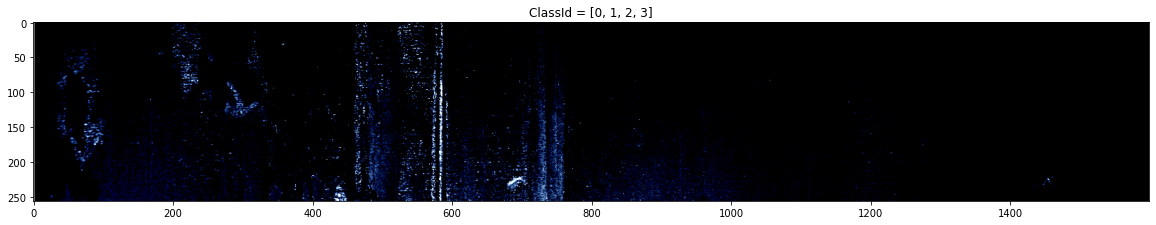

In [37]:
show_image_mask(225, image = test_data[0][0].permute(1, 2, 0), mask = masks.detach())

Сравнение предсказанного:

In [30]:
threshold_mask_pixel = [ 0.2, 0.2, 0.2, 0.2]

def get_normal_pred_mask(mask, class_id = [0,1,2,3]):
    for i in class_id:
        mask[i] = (mask[i] > threshold_mask_pixel[i]).type(mask[i].dtype)
    return mask[i]

In [19]:
def run_length_encode(mask):
    m = mask.T.flatten()
    if m.sum()==0:
        rle=''
    else:
        m   = np.concatenate([[0], m, [0]])
        run = np.where(m[1:] != m[:-1])[0] + 1
        run[1::2] -= run[::2]
        rle = ' '.join(str(r) for r in run)
    return rle

In [20]:
imgs_names = []
encoded_pixels = []

threshold_mask_pixel = [ 0.45, 0.45, 0.40, 0.40]
model = torch.load("test1.pth")
model = model.to(device)
model.eval()

for imgs, img_names in test_loader:
    
  imgs = imgs.to(device)
  imgs.shape
  
  masks = model(imgs).to('cpu')
  imgs.to("cpu")
    
  print(img_names)

  for batch_num in range(len(imgs)):
    img_name = img_names[batch_num]
    mask = masks[batch_num]

    for class_id in range(4):
      imgs_names.append(img_name+'_'+str(class_id+1))

      m = get_normal_pred_mask(mask, [class_id])
      
      
      encoded_pixels.append(run_length_encode(m.detach().numpy()))
        
  del imgs

('0000f269f.jpg', '000ccc2ac.jpg')
('002451917.jpg', '003c5da97.jpg')
('0042e163f.jpg', '004f40c73.jpg')
('00513039a.jpg', '006f39c41.jpg')
('008725cbc.jpg', '0098ca44e.jpg')
('00a0b7730.jpg', '00a0f9949.jpg')
('00b000b81.jpg', '00b7fb703.jpg')
('00bbcd9af.jpg', '00d72c660.jpg')
('00df5b714.jpg', '00f3799a7.jpg')
('0108ce457.jpg', '0109b68ec.jpg')
('010ec96b4.jpg', '011a7e2a9.jpg')
('0126f74ef.jpg', '012754bbb.jpg')
('01588ee42.jpg', '015be539e.jpg')
('017796c88.jpg', '017bd7ce3.jpg')
('018d7b0a1.jpg', '019258298.jpg')
('0197bb47e.jpg', '01b17e176.jpg')
('01b2163b7.jpg', '01b47d973.jpg')
('01b50837f.jpg', '01cc31534.jpg')
('01d3e8fcb.jpg', '01d49cd47.jpg')
('01db22c17.jpg', '01e640f20.jpg')
('020ffb2d3.jpg', '021656fe0.jpg')
('02217a5cc.jpg', '0224561d0.jpg')
('0241cf678.jpg', '0246ad619.jpg')
('02538bec6.jpg', '02662fd2f.jpg')
('0280c72a9.jpg', '028aca84a.jpg')
('029e85b9e.jpg', '02a2397e9.jpg')
('02a5c3ba0.jpg', '02aeac4e1.jpg')
('02ba931ee.jpg', '02d5824f4.jpg')
('02d963811.jpg', '0

('165be877c.jpg', '1661a5935.jpg')
('1665a9aa3.jpg', '166df66fa.jpg')
('1672505e5.jpg', '167a15e46.jpg')
('168d569cb.jpg', '16b4b381f.jpg')
('16b6212be.jpg', '16c25e5bd.jpg')
('16c79808e.jpg', '16c84984c.jpg')
('16d77499b.jpg', '16dc18581.jpg')
('16e5cabec.jpg', '16eb22c40.jpg')
('1709a0811.jpg', '171ff4d5d.jpg')
('173263982.jpg', '1748f0bd2.jpg')
('1759e4b70.jpg', '176b6a74b.jpg')
('17824cd96.jpg', '179a5ea0b.jpg')
('17a654936.jpg', '17a6dce92.jpg')
('17b3cd0d9.jpg', '17bc2934d.jpg')
('17cc619b0.jpg', '17f40ff23.jpg')
('17f6716dd.jpg', '1800f04df.jpg')
('1804f41eb.jpg', '180750e88.jpg')
('1808f2da2.jpg', '180c1ef29.jpg')
('180c38495.jpg', '180e4c980.jpg')
('183a346ed.jpg', '183ee6fa4.jpg')
('184c34cbf.jpg', '1851312f7.jpg')
('1859bb7f6.jpg', '18617aa7b.jpg')
('1865593bf.jpg', '186c47869.jpg')
('18beca643.jpg', '18d7c86bd.jpg')
('18db458af.jpg', '18df56cd6.jpg')
('19020daa4.jpg', '1924ec417.jpg')
('193acb58d.jpg', '19439013c.jpg')
('1949816d9.jpg', '195305ea0.jpg')
('195b0a65d.jpg', '1

('2d3b1ad23.jpg', '2d5a400dd.jpg')
('2d6adba8c.jpg', '2d7979826.jpg')
('2d7c8c432.jpg', '2d8fa3ef6.jpg')
('2d905add8.jpg', '2d9a3580f.jpg')
('2dacfac73.jpg', '2dba99f31.jpg')
('2dbd4efce.jpg', '2df0b28cd.jpg')
('2df34e86d.jpg', '2e00fee4c.jpg')
('2e0e61fc8.jpg', '2e1014fb7.jpg')
('2e19d94c0.jpg', '2e2429762.jpg')
('2e271886d.jpg', '2e4095351.jpg')
('2e5393458.jpg', '2e584cc63.jpg')
('2e65b8365.jpg', '2e6e52df6.jpg')
('2e820273b.jpg', '2e92003f5.jpg')
('2ea109f84.jpg', '2ea56c9de.jpg')
('2eab69ac9.jpg', '2eb1e6465.jpg')
('2eb811b0c.jpg', '2ebe3686e.jpg')
('2ec632269.jpg', '2edfdf413.jpg')
('2efa6b22f.jpg', '2f17451ae.jpg')
('2f287e453.jpg', '2f28ac518.jpg')
('2f470be2e.jpg', '2f502ea2a.jpg')
('2f52bbc6f.jpg', '2f79a61a4.jpg')
('2f80fed37.jpg', '2f97adb98.jpg')
('2f985430a.jpg', '2fa3d820b.jpg')
('2fba1660a.jpg', '2fd107727.jpg')
('2fd5af1e9.jpg', '2fdbd1d31.jpg')
('2fe2187a9.jpg', '2fed1cf68.jpg')
('2ffd7fe3c.jpg', '3008b56a6.jpg')
('30144acd5.jpg', '301c32a3a.jpg')
('302217674.jpg', '3

('429a2d97a.jpg', '429a6437d.jpg')
('42a7c4cd4.jpg', '42aa6fd93.jpg')
('42ac758fc.jpg', '42ae82ae2.jpg')
('42c3f7b08.jpg', '42d4d28f6.jpg')
('42e6c728d.jpg', '42f162eec.jpg')
('42f269efe.jpg', '42f2b7c8e.jpg')
('43002ba30.jpg', '43129c346.jpg')
('43174e99b.jpg', '431a9ccc3.jpg')
('431e86caa.jpg', '431ef181d.jpg')
('432cc82fe.jpg', '4333ec468.jpg')
('4337d169a.jpg', '433ecc86d.jpg')
('43440f039.jpg', '43558fbec.jpg')
('435e66b3a.jpg', '4360329d0.jpg')
('437271da1.jpg', '438ad7d10.jpg')
('439133dbf.jpg', '439973eed.jpg')
('439feac51.jpg', '43a10ca4f.jpg')
('43a20b18b.jpg', '43b0dec37.jpg')
('43b6a6a1a.jpg', '43be155b2.jpg')
('43c1a4a70.jpg', '43cdf7d8d.jpg')
('43d3e6f33.jpg', '43e98ae7e.jpg')
('43fe37865.jpg', '4425a3ca1.jpg')
('44398db54.jpg', '443d3ddd0.jpg')
('44458e244.jpg', '44529076b.jpg')
('4453800c1.jpg', '445451d11.jpg')
('44578c960.jpg', '445a4f77f.jpg')
('446372a47.jpg', '448546cd8.jpg')
('44859b1b9.jpg', '448a73204.jpg')
('4490e43c1.jpg', '44a556271.jpg')
('44a5dd5b9.jpg', '4

('58f6093db.jpg', '58fbd1a0d.jpg')
('5900ac269.jpg', '590aa4bfc.jpg')
('5943020f6.jpg', '5943b12cf.jpg')
('594556fb4.jpg', '5945a8248.jpg')
('594bc49fd.jpg', '595426f59.jpg')
('595bd6fcf.jpg', '5976e13d9.jpg')
('5992b1f0d.jpg', '5998eee37.jpg')
('599f73dd0.jpg', '59a40ecca.jpg')
('59b42a129.jpg', '59c0a3475.jpg')
('59c2fdc9e.jpg', '59ed4aa3d.jpg')
('59eff5e14.jpg', '5a0ce7a50.jpg')
('5a1b85353.jpg', '5a25d5a5c.jpg')
('5a2f952d9.jpg', '5a6cc72c5.jpg')
('5a72c9adc.jpg', '5a7c94126.jpg')
('5a9149cad.jpg', '5a9444ea9.jpg')
('5a9a84c90.jpg', '5aa035361.jpg')
('5aa3780c6.jpg', '5aac82fa3.jpg')
('5aacbd81b.jpg', '5abda8a7d.jpg')
('5ae4f1314.jpg', '5ae58f03b.jpg')
('5aed4bb1a.jpg', '5afaa1617.jpg')
('5b0021aa9.jpg', '5b13f920c.jpg')
('5b1668f62.jpg', '5b1e65973.jpg')
('5b3a4b5ad.jpg', '5b4743e28.jpg')
('5b4d84943.jpg', '5b4e2745d.jpg')
('5b598c70c.jpg', '5b6095b41.jpg')
('5b65a330b.jpg', '5ba0fddcf.jpg')
('5ba25ce9e.jpg', '5ba631a31.jpg')
('5bb3b7c79.jpg', '5bbbd9386.jpg')
('5bbdf1b40.jpg', '5

('6e8b36bc6.jpg', '6e9bf11c0.jpg')
('6ead29619.jpg', '6eb8caa4a.jpg')
('6eba02cd9.jpg', '6ec0efcf3.jpg')
('6ed28df8e.jpg', '6edb49569.jpg')
('6edde1c34.jpg', '6ee58e663.jpg')
('6eeb2c1e3.jpg', '6eec49a0b.jpg')
('6ef6001e9.jpg', '6ef75490b.jpg')
('6f0358b25.jpg', '6f0647c4e.jpg')
('6f12a26e0.jpg', '6f18c587b.jpg')
('6f1b804af.jpg', '6f3527745.jpg')
('6f377b22a.jpg', '6f3bd83c8.jpg')
('6f5e81ff8.jpg', '6f6753eb7.jpg')
('6f7f8d8a8.jpg', '6f808d1d1.jpg')
('6f88c6d64.jpg', '6f8f7489b.jpg')
('6f95d5d44.jpg', '6fa8c306d.jpg')
('6fae55fc7.jpg', '6faf02aec.jpg')
('6fc70467c.jpg', '6fcc14128.jpg')
('6fd029d4d.jpg', '6fdb86bdf.jpg')
('6fe34f1ef.jpg', '6fe8dbcbb.jpg')
('7015966f2.jpg', '701d9155f.jpg')
('7021b1976.jpg', '702d70516.jpg')
('703977991.jpg', '706930f56.jpg')
('706f2b2c9.jpg', '7080127e8.jpg')
('7081b8507.jpg', '70853595b.jpg')
('708f5f3ba.jpg', '708faeb3c.jpg')
('70a822722.jpg', '70aca6bc2.jpg')
('70b6b9ce6.jpg', '70fb25903.jpg')
('70fb7e23e.jpg', '71069d6a0.jpg')
('7117d7c5f.jpg', '7

('83f043cea.jpg', '83f590eb5.jpg')
('83f8bc981.jpg', '83fb62633.jpg')
('83fe02b94.jpg', '841205686.jpg')
('841305fc9.jpg', '84273b428.jpg')
('8430c2ce9.jpg', '8446c7668.jpg')
('844cccf91.jpg', '844d1610d.jpg')
('8455f4fef.jpg', '84594a283.jpg')
('845cefdc3.jpg', '845ea6711.jpg')
('84625cf81.jpg', '84652c588.jpg')
('8469d36bf.jpg', '846fff7a8.jpg')
('8475899d7.jpg', '8486cd41b.jpg')
('848be142e.jpg', '84a86bda1.jpg')
('84add8883.jpg', '84b10856b.jpg')
('84b51fda5.jpg', '84bdf6af0.jpg')
('84c31d0e6.jpg', '84cf5227c.jpg')
('84e348664.jpg', '84e5b87d3.jpg')
('84ef50751.jpg', '850b69e1e.jpg')
('8514adb31.jpg', '851c13f4b.jpg')
('851d08c7e.jpg', '852e75b64.jpg')
('8537ff65f.jpg', '85479d313.jpg')
('854cc93ba.jpg', '8553cb317.jpg')
('85620a8c1.jpg', '856227c65.jpg')
('856ef5d4e.jpg', '858e74ccd.jpg')
('85cdc422f.jpg', '85d9d5cbb.jpg')
('85dccb649.jpg', '85de2ae47.jpg')
('85eb63383.jpg', '85ee230e3.jpg')
('85f91fed5.jpg', '86158d6eb.jpg')
('8629ee178.jpg', '863834f74.jpg')
('8640a1010.jpg', '8

('997368746.jpg', '99976696b.jpg')
('99ac0a458.jpg', '99c9b2546.jpg')
('99ced6e4a.jpg', '99efed4b3.jpg')
('99f890650.jpg', '99fb3d0d5.jpg')
('9a17ac108.jpg', '9a2c2d41e.jpg')
('9a52fa414.jpg', '9a56a6690.jpg')
('9a8a05d65.jpg', '9a8ee5f00.jpg')
('9a915d960.jpg', '9a9703e3c.jpg')
('9aa6cf465.jpg', '9aac3187b.jpg')
('9ab374aaf.jpg', '9abf4e920.jpg')
('9ad96011f.jpg', '9add1b7db.jpg')
('9aec02d72.jpg', '9aee368c0.jpg')
('9b06a292b.jpg', '9b16a82de.jpg')
('9b188741b.jpg', '9b23c3d12.jpg')
('9b4e0f08d.jpg', '9b5074b6d.jpg')
('9b5147492.jpg', '9b5606333.jpg')
('9b569f979.jpg', '9b66b8330.jpg')
('9b6f683af.jpg', '9b787b3f3.jpg')
('9b84b513e.jpg', '9b953552b.jpg')
('9b9bb345b.jpg', '9bf40f9c2.jpg')
('9c05b3377.jpg', '9c1af32c2.jpg')
('9c1fff809.jpg', '9c2aacdd8.jpg')
('9c2ef44cc.jpg', '9c3265f8a.jpg')
('9c331e570.jpg', '9c595e23e.jpg')
('9c5b6cb95.jpg', '9c5b7cb71.jpg')
('9c60f3644.jpg', '9c6b31c97.jpg')
('9c79a95ce.jpg', '9c98a69b7.jpg')
('9ca124aa0.jpg', '9cb6d4832.jpg')
('9cbc700db.jpg', '9

('aee588c2a.jpg', 'aeed25930.jpg')
('aef263cee.jpg', 'aefeb52b4.jpg')
('af36b78de.jpg', 'af3878f3f.jpg')
('af47b5cab.jpg', 'af4a7a808.jpg')
('af59fd793.jpg', 'af5ab66fe.jpg')
('af5d1c279.jpg', 'af5d777f6.jpg')
('af66b85fd.jpg', 'af71eb041.jpg')
('af74aa160.jpg', 'af83baf22.jpg')
('afa15b5c9.jpg', 'afaafa0e2.jpg')
('afab00de8.jpg', 'afc3e3e90.jpg')
('afc80ea04.jpg', 'afd915ef5.jpg')
('afe8a8218.jpg', 'afeaaf75b.jpg')
('afec9857d.jpg', 'affcfaa11.jpg')
('b002af890.jpg', 'b0050b626.jpg')
('b015e3b0b.jpg', 'b021c2920.jpg')
('b03b804f4.jpg', 'b04479d29.jpg')
('b05447a7e.jpg', 'b058dff03.jpg')
('b05abc345.jpg', 'b069e70a9.jpg')
('b06ec3c11.jpg', 'b075c1f75.jpg')
('b083b122f.jpg', 'b09d43553.jpg')
('b0aa870f4.jpg', 'b0b36ec1c.jpg')
('b0b5a3357.jpg', 'b0cbdf92b.jpg')
('b0d4531cd.jpg', 'b0f02f147.jpg')
('b10f023a7.jpg', 'b110498f7.jpg')
('b11249b57.jpg', 'b1166a68f.jpg')
('b1410944a.jpg', 'b14c8bd75.jpg')
('b15044224.jpg', 'b15207e5a.jpg')
('b155a3831.jpg', 'b15bf05e4.jpg')
('b15d43ae2.jpg', 'b

('c57bbee34.jpg', 'c588f15f5.jpg')
('c590cb628.jpg', 'c5971928d.jpg')
('c5b81a129.jpg', 'c5bd13a82.jpg')
('c5bdaa12a.jpg', 'c5c550269.jpg')
('c5c99623d.jpg', 'c5ea5ede3.jpg')
('c5eb5b8ef.jpg', 'c5f22d971.jpg')
('c5fdc7085.jpg', 'c61c8dd6b.jpg')
('c62df418e.jpg', 'c6373dff3.jpg')
('c63ec6dd2.jpg', 'c641e799b.jpg')
('c658c42ca.jpg', 'c66f8a343.jpg')
('c66fe5faa.jpg', 'c67587070.jpg')
('c6820e0fd.jpg', 'c69adf2c4.jpg')
('c6b5ec73d.jpg', 'c6b9a2ac0.jpg')
('c6bc7ca4b.jpg', 'c6beaa7d0.jpg')
('c6de9db6e.jpg', 'c6e79ad5d.jpg')
('c6f648543.jpg', 'c6fc7eb80.jpg')
('c6fe30fe6.jpg', 'c707919df.jpg')
('c70b53a15.jpg', 'c70ce636e.jpg')
('c70f0b7c0.jpg', 'c70f8c5e0.jpg')
('c716d86d5.jpg', 'c71c89af8.jpg')
('c71eb4e51.jpg', 'c723f1ada.jpg')
('c724c62c2.jpg', 'c725bafda.jpg')
('c730de63c.jpg', 'c7335eee0.jpg')
('c759436cd.jpg', 'c7667ac1b.jpg')
('c76cf4783.jpg', 'c77c67b9a.jpg')
('c7865cb81.jpg', 'c7abcfd22.jpg')
('c7d5147b1.jpg', 'c7f0c9b72.jpg')
('c7f574347.jpg', 'c7fb01bad.jpg')
('c7ff73078.jpg', 'c

('dbeb33ddc.jpg', 'dbefb141e.jpg')
('dbf5acb5e.jpg', 'dbfc43562.jpg')
('dc074ffd3.jpg', 'dc0cc9179.jpg')
('dc108224f.jpg', 'dc1283e68.jpg')
('dc2033d9a.jpg', 'dc2205ab2.jpg')
('dc2389797.jpg', 'dc265fa8b.jpg')
('dc2977a7c.jpg', 'dc3090141.jpg')
('dc33467ce.jpg', 'dc4f9fc81.jpg')
('dc5acf74b.jpg', 'dc5c24d9f.jpg')
('dc5d220aa.jpg', 'dc74717d9.jpg')
('dc7a4ab17.jpg', 'dc852d7bc.jpg')
('dc89301ff.jpg', 'dc8b0afdb.jpg')
('dc8d040ab.jpg', 'dc9f2a84b.jpg')
('dca50791d.jpg', 'dcc359aca.jpg')
('dcdfc29b2.jpg', 'dcebca3d6.jpg')
('dcef185c1.jpg', 'dcf0cab3d.jpg')
('dd135f9ec.jpg', 'dd37b174a.jpg')
('dd4531cef.jpg', 'dd460a71f.jpg')
('dd522b9fe.jpg', 'dd571d45c.jpg')
('dd77c2560.jpg', 'dd7e2d6f5.jpg')
('dd7f00ee2.jpg', 'dd8b6bbc0.jpg')
('dd9364137.jpg', 'ddca8eddd.jpg')
('ddd51fc3b.jpg', 'dde40f6ee.jpg')
('ddedcc295.jpg', 'de0344beb.jpg')
('de1752dbc.jpg', 'de1ca9faf.jpg')
('de1cbc142.jpg', 'de204c923.jpg')
('de2a1c17e.jpg', 'de2df260c.jpg')
('de30f5435.jpg', 'de3697a6b.jpg')
('de380b874.jpg', 'd

('f1a06d4bc.jpg', 'f1a43aa49.jpg')
('f1aa776be.jpg', 'f1c28d5d4.jpg')
('f1d16bebb.jpg', 'f1d2a3de3.jpg')
('f1d34218a.jpg', 'f1d90c01a.jpg')
('f1d98dffe.jpg', 'f1ef7c8af.jpg')
('f1ff7d363.jpg', 'f21c3fb83.jpg')
('f2313afbd.jpg', 'f235a7eec.jpg')
('f246790fc.jpg', 'f250fc64b.jpg')
('f25152812.jpg', 'f27c44348.jpg')
('f289fa572.jpg', 'f28b12b37.jpg')
('f29367e35.jpg', 'f29eea44e.jpg')
('f2aebd6c2.jpg', 'f2cca0c48.jpg')
('f2e101daa.jpg', 'f2e5124ff.jpg')
('f2f72af0b.jpg', 'f30dadc8a.jpg')
('f32d1ef36.jpg', 'f3359c2a2.jpg')
('f33e07648.jpg', 'f36ca6bba.jpg')
('f3760f8af.jpg', 'f39068d43.jpg')
('f3a48ec4f.jpg', 'f3e31ebb4.jpg')
('f3e43b28e.jpg', 'f3f84fd8a.jpg')
('f402a48fa.jpg', 'f41dde33c.jpg')
('f421a4077.jpg', 'f425a321c.jpg')
('f43b58b4b.jpg', 'f44ab2bbf.jpg')
('f44b60b51.jpg', 'f4556e0db.jpg')
('f462d760b.jpg', 'f46e7dce1.jpg')
('f472e6982.jpg', 'f4764309b.jpg')
('f493efb68.jpg', 'f49971678.jpg')
('f49af581c.jpg', 'f4ab50226.jpg')
('f4ac9794b.jpg', 'f4bc14256.jpg')
('f4c03d027.jpg', 'f

In [22]:
torch.save(model.state_dict(),"test1_sd.pth")

In [21]:
sb = pd.DataFrame({
    'ImageId_ClassId': imgs_names,
    'EncodedPixels': encoded_pixels
})

sb.to_csv('submission.csv')